In [43]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from timeit import default_timer as timer
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

In [125]:
def modal_sum(w, a_n, z_n, w_n, sigma=0.1):
    tf = np.zeros_like(w, dtype=np.complex128)
    for i in range(len(a_n)):
        tf += a_n[i] / (w_n[i]**2 - w**2 + 1j * 2 * z_n[i] * w * w_n[i])
    noise = np.random.normal(0, sigma, len(w)) + 1j * np.random.normal(0, sigma, len(w))
    tf += noise

    y = np.zeros(len(w))
    for i, w_n_value in enumerate(w_n):
        # Ensure at least one positive label for thin peaks with low damping
        closest_index = np.argmin(np.abs(w - w_n_value))
        y[closest_index] = 1
        # Label points within half power bandwidh as positive
        dw = w_n_value * z_n[i]
        indices_in_range = np.where((w >= w_n_value - dw) & (w <= w_n_value + dw))
        y[indices_in_range] = 1


    return tf, y

In [7]:
def split_real_imag(x: np.ndarray) -> np.ndarray:
    return np.column_stack((np.real(x), np.imag(x)))

In [186]:
def generate_data(num_data, num_w_points):
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(1, 2)
        w_n = np.random.uniform(0, 1, num_modes)
        a_n = np.random.uniform(1, 2, num_modes)
        z_n = np.random.uniform(0.01, 0.20, num_modes)
        sigma = np.random.uniform(0.01, 0.15)
        out, y = modal_sum(w, a_n, z_n, w_n, sigma)
        ws.append(w_n)
        zs.append(z_n)
        X.append(split_real_imag(out))
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [9]:
def to_db(x):
    if x.shape[-1] == 2:
        return 20 * np.log10(np.linalg.norm(x, axis=-1))
    return 20 * np.log10(np.abs(x))

In [187]:
def plot_tf(tf, y, todb=False):
    fig, ax = plt.subplots()
    w = np.linspace(0, 1, len(y))
    if todb:
        ax.plot(w, to_db(tf))
        for i in range(len(w)):
            if y[i] == 1:
                ax.scatter(w[i], to_db(tf)[i], c='red', marker='o')
    else:
        tf_vals = np.linalg.norm(tf, axis=-1)
        ax.plot(w, tf_vals)
        for i in range(len(w)):
            if y[i] == 1:
                ax.scatter(w[i], tf_vals[i], c='red', marker='o')
            
    # plt.show()
    return fig, ax

In [18]:
test = [[[3,4j],[6,8j],[-1j,3]], [[3,4],[6,8],[1,3]]]
test = np.array(test)
print(test.shape)
print(np.linalg.norm(test, axis=-1))
print(np.log10(np.linalg.norm(test, axis=-1)))

(2, 3, 2)
[[ 5.         10.          3.16227766]
 [ 5.         10.          3.16227766]]
[[0.69897 1.      0.5    ]
 [0.69897 1.      0.5    ]]


In [243]:
X,y,ws,zs = generate_data(2, 10)
print(X[0])
print(np.linalg.norm(X[0], axis=0))


[[  4.3488811    0.1100001 ]
 [  4.65819065  -0.38376712]
 [  4.89673174  -0.48676896]
 [  5.28540456  -1.62379709]
 [  6.37378003  -2.87635534]
 [  6.70403017  -6.61028796]
 [  0.81446427 -11.21786247]
 [ -4.50131454  -6.51903801]
 [ -4.02869607  -2.84072939]
 [ -3.12919748  -1.83997201]]
[15.00138447 15.32305128]


In [244]:
X_norm = X / np.linalg.norm(X, axis=0, keepdims=True)
print(X_norm[0])

min_vals = np.min(X, axis=1, keepdims=True)
max_vals = np.max(X, axis=1, keepdims=True)
X_norm2 = (X-min_vals) / (max_vals-min_vals)
X_norm2 = -1 + 2 * X_norm2
print(X_norm2[0])
# print(np.linalg.norm(X_norm2, axis=-1)[0])

[[ 0.88248484  0.50455427]
 [ 0.88042818 -0.92591005]
 [ 0.88409964 -0.77690747]
 [ 0.88278566 -0.91642972]
 [ 0.88056952 -0.93625589]
 [ 0.8456802  -0.93220095]
 [ 0.24657398 -0.87420836]
 [-0.90141604 -0.73375776]
 [-0.81454577 -0.77321614]
 [-0.83268788 -0.84259144]]
[[ 0.57963826  1.        ]
 [ 0.63484577  0.91282253]
 [ 0.67742207  0.89463695]
 [ 0.74679483  0.69388803]
 [ 0.94105489  0.47274158]
 [ 1.         -0.18650593]
 [-0.05120655 -1.        ]
 [-1.         -0.17039522]
 [-0.9156441   0.47903155]
 [-0.75509597  0.65572109]]


In [240]:
test_arr = [[[1,2],[3,4],[5,6]], [[1,2],[3,4],[5,6]]]
test_arr = np.array(test_arr)
min_vals = np.min(test_arr, axis=1, keepdims=True)
max_vals = np.max(test_arr, axis=1, keepdims=True)
print(test_arr.shape)
print(min_vals)
print(max_vals)
print((test_arr-min_vals) / (max_vals-min_vals))

(2, 3, 2)
[[[1 2]]

 [[1 2]]]
[[[5 6]]

 [[5 6]]]
[[[0.  0. ]
  [0.5 0.5]
  [1.  1. ]]

 [[0.  0. ]
  [0.5 0.5]
  [1.  1. ]]]


In [218]:
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X[0])
print(X_minmax)

[[0.66502515 1.        ]
 [0.6769179  0.98093911]
 [0.72984745 0.92423138]
 [1.         0.38954738]
 [0.         0.        ]
 [0.37792931 0.90626944]
 [0.44626601 0.96814583]
 [0.47411589 0.98253715]
 [0.48839768 0.99070108]
 [0.49691898 0.99374022]]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

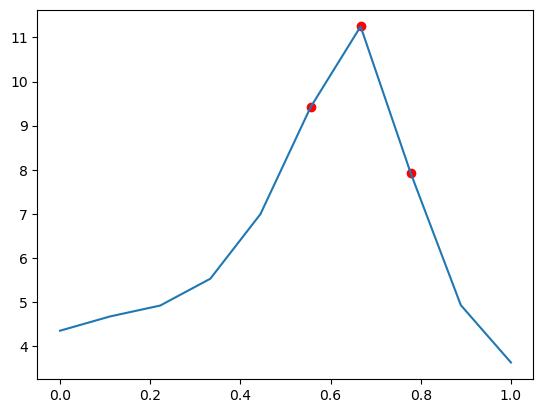

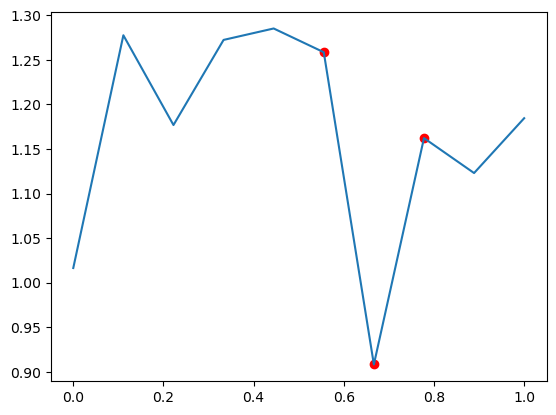

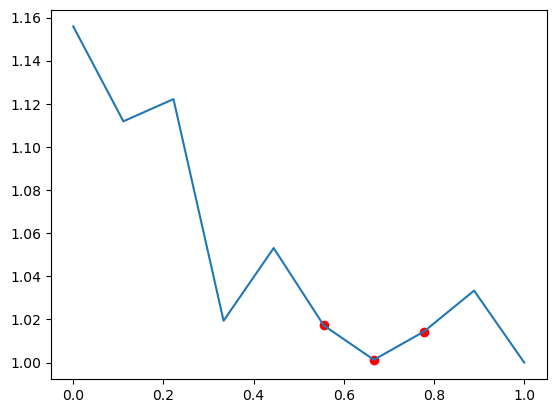

In [245]:
plot_tf(X[0], y[0], todb=False)
plot_tf(X_norm[0], y[0], todb=False)
plot_tf(X_norm2[0], y[0], todb=False)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

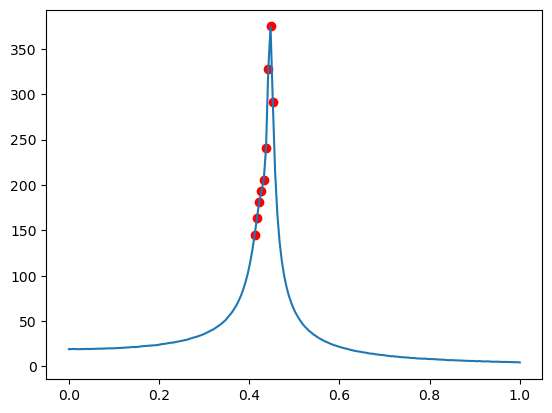

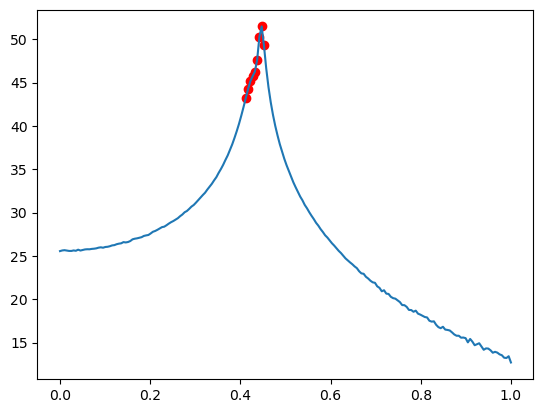

In [159]:
X1,y1,_,__ = generate_data(1, 200)
plot_tf(X1[0], y1[0], todb=False)
plot_tf(X1[0], y1[0], todb=True)
